In [1]:
import numpy as np
import gym
import gym_crumb
from math import radians
import rospy


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
env = gym.make("crumb-pick-v0")

In [9]:
env.reset()

[0.00015711222384595658,
 0.009900520270559987,
 -0.00702721148400709,
 -0.007881893475730095,
 0.00037148649592921856]

In [4]:
from qlearning_pick import QLearningAgent
agent = QLearningAgent(alpha=0.25,epsilon=0.8,discount=0.99)

In [5]:
sign = lambda a: 1 if a>0 else -1 if (a<0) else 0
def signs(vec_a):
    signs = np.zeros(len(vec_a))
    for i in range(len(vec_a)):
        signs[i] = sign(vec_a[i])
    return signs
        
        
def module(vec_a):
    return (vec_a**2).sum()**(0.5)

def angle(vec_a, vec_b):
    return np.arccos((vec_a*vec_b).sum(axis = 1)/(module(vec_a) * module(vec_b)))
def norm(vec_a):
    norm = np.zeros_like(vec_a)
    for i in range(len(vec_a)):
        norm[i][0] = -vec_a[i][1]
        norm[i][1] = vec_a[i][0]
    return norm
        
def get_xz(joint):
    a = env.link_state(joint, '').link_state.pose.position
    return np.array([a.x, a.z])

def get_xy(joint):
    a = env.link_state(joint, '').link_state.pose.position
    return np.array([a.x, a.y])

In [6]:
def state1(aim = env.aim):
    aim1 = np.array([aim.x, aim.z])
    aim1_gor = np.array([aim.x, aim.y])

    #Joints pose vert
    joint = np.zeros((6,2))
    joint[0] = get_xz('biceps_link')
    joint[1] = get_xz('forearm_link')
    joint[2] = get_xz('wrist_1_link')
    joint[3] = get_xz('gripper_1_link')
    
    #Joints pose gor
    joint[4] = get_xy('gripper_1_link')
    joint[5] = get_xy('biceps_link')
    
    #vectors
    vec1 = np.zeros((3,2))
    vec2 = np.zeros((3,2))
    vec3 = np.zeros((1,2))
    vec4 = np.zeros((1,2))
    
    vec3[0] = joint[4] - joint[5]
    vec4[0] = aim1_gor - joint[5]
    for i in range(3):
        vec1[i] = joint[3] - joint[i]
        vec2[i] = aim1 - joint[i]
    
    
    state1 = signs(angle(norm(vec1), vec2) - np.full(3, radians(90)))
    state2 = signs(angle(norm(vec3), vec4) - np.full(3, radians(90))) #вестор из 1, -1, 0
    return (tuple(state1), tuple(state2))
     

In [27]:
env.step([1, radians(0)])

([0.4016026162957722,
  0.385432078132367,
  -0.2367501358963695,
  0.7011030906649705,
  -0.000668670961865736],
 -4.0,
 False)

In [7]:
def play_and_train(env,agent,t_max=10**3):

    total_reward = 0.0
    s = env.reset()
    r = 0
    #env.step((3, radians(0)))
    for t in range(t_max):
        state = state1()#state for agent, s for gazebo
        action = agent.getAction(state)#<get agent to pick action given state s>
        env.aim = env.box_state('little_box_0', 'link').pose.position
        a = (action[0], action[1] + s[action[0]]) 
        next_s,r, done = env.step(a)
        next_state = state1()
        agent.update(state, action, next_state, r)#<train (update) agent for state s>
        
        s = next_s
        total_reward +=r
        if done:
            agent.epsilon = agent.epsilon * 0.8
            if agent.epsilon < 0.09:
                env.gripper.publish(0.0)
                rospy.sleep(2.0)
                env.step([1, radians(0)])
                rospy.sleep(2.0)
                env.gripper.publish(2.0)
                rospy.sleep(2.0)
            print ('yyes')
            break
    return total_reward
    
        
    

aim = (0, 3)

mean reward 84.0


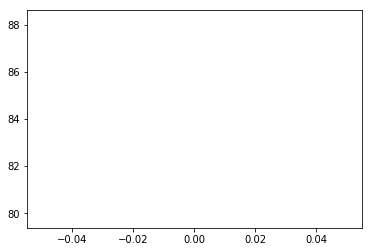

yyes
yyes
yyes
yyes
yyes
yyes
yyes
yyes
yyes
yyes
yyes
yyes


In [ ]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i % 100 == 0:
        clear_output(True)
        print ("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        

aim = (2, 1)

In [23]:
agent.epsilon

0.08589934592000005

mean reward -32.0


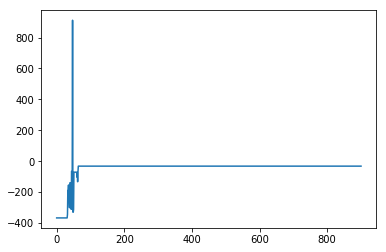

In [26]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))    
    if i % 100 == 0:
        clear_output(True)
        print ("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()

In [27]:
agent.epsilon

1e-323

In [8]:
def play(env, agent, t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    r = 0
    #env.step((3, radians(0)))
    for t in range(t_max):
        a = agent.getPolicy(tuple(s))#<get agent to pick action given state s>
        
        next_s,r, done = env.step(a)
        print (r)
        
        #agent.update(tuple(s), a, tuple(next_s), r)#<train (update) agent for state s>
        
        s = next_s
        total_reward +=r
        if done:break
    return total_reward